In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import psycopg2
import os

FILENAME = 'Shiftsmart Case Study - Business + Product - Dataset.xlsx'
raw = pd.read_excel(f'../data/{FILENAME}')
raw


,shift_UUID,market,store,role,shift_date,shift_dow,shift_hour,duration,rate,base_wage_potential,...,canceled_late,noShow,Confirmed_noShow,NotConfirmed_noShow,completed,eligble_partners,n_sent_partners,n_accepted_partners,n_miles_completed,n_not_sent
0,ea3da3ea-d642-4db3-b7b3-c58d4ddf8ad7,NaN,NaN,Role 1,2022-01-03,2,16,4.0,12.0,48.0,...,0,1,1,0,0,27,15,1,NaN,0
1,7e8117a2-6623-4352-b499-12bda78e8330,NaN,NaN,Role 1,2022-01-07,6,7,4.0,13.0,52.0,...,0,0,0,0,1,29,20,1,30.000000,0
2,4d3102b5-ab7a-4cfe-9d1f-1a36d53df94f,NaN,NaN,Role 1,2022-01-14,6,7,4.0,13.0,52.0,...,0,0,0,0,1,11,11,1,30.000000,0
3,409d9c07-64a9-4ef0-bafc-42fcd3c135f2,NaN,NaN,Role 1,2022-01-17,2,20,4.0,12.0,48.0,...,0,1,1,0,0,238,238,3,NaN,0
4,f0b25bf8-a46e-428b-9453-8abab9a0cc2e,NaN,NaN,Role 1,2022-01-10,2,17,4.0,12.0,48.0,...,0,0,0,0,1,11,0,1,30.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,a51eec8c-f404-4a23-b8ac-6b692b2bc2c3,4378,4701392.0,Role 1,2022-01-17,2,18,4.0,12.0,48.0,...,0,1,1,0,0,4,4,1,NaN,0
16476,21a8793a-7e9e-4f31-9b72-204c27b6c5db,4378,4701392.0,Role 1,2022-01-13,5,22,4.0,12.0,48.0,...,0,1,1,0,0,64,48,1,NaN,0
16477,2e3085f5-172f-42f2-a48a-5194d5a8fe5c,4378,4701392.0,Role 1,2022-01-10,2,21,4.0,12.0,48.0,...,0,0,0,0,1,48,48,1,3.168714,0
16478,e79959ed-baf3-4b8d-8609-5d79a00e78b1,4378,4701392.0,Role 3,2022-01-13,5,22,4.0,12.0,48.0,...,0,1,1,0,0,65,48,1,NaN,0


In [26]:
raw.columns

Index(['shift_UUID', 'market', 'store', 'role', 'shift_date', 'shift_dow',
       'shift_hour', 'duration', 'rate', 'base_wage_potential',
       'total_wage_potential', 'bonus', 'completed_partner', 'n_sent',
       'n_sent_miles_0_5', 'n_sent_miles_6_10', 'n_sent_miles_11_15',
       'n_sent_miles_16_20', 'n_sent_miles_21_25', 'n_sent_miles_26_30',
       'n_sent_miles_30_100', 'n_accepted', 'no_accepts', 'canceled_early',
       'canceled_late', 'noShow', 'Confirmed_noShow', 'NotConfirmed_noShow',
       'completed', 'eligble_partners', 'n_sent_partners',
       'n_accepted_partners', 'n_miles_completed', 'n_not_sent'],
      dtype='object')

## Integrity Checks

In [27]:
# Calculate % missing for each column
missing = raw.isnull().mean().sort_values(ascending=False) * 100

# Filter for columns with > 0% missing
missing = missing[missing > 0].reset_index()
missing.columns = ['column', 'pct_missing']

print(missing)

                  column  pct_missing
0                  bonus    45.230583
1      n_miles_completed    39.132282
2      completed_partner    38.962379
3      n_sent_miles_6_10     0.303398
4     n_sent_miles_16_20     0.303398
5                   rate     0.303398
6       n_sent_miles_0_5     0.303398
7   total_wage_potential     0.303398
8               duration     0.303398
9    base_wage_potential     0.303398
10    n_sent_miles_26_30     0.303398
11   n_sent_miles_30_100     0.303398
12    n_sent_miles_21_25     0.303398
13    n_sent_miles_11_15     0.303398
14                 store     0.060680
15                market     0.060680


In [78]:
rows_completed_missing_distance = raw.loc[raw.n_miles_completed.isna() & raw.completed == 1] # no missing rows for completed shifts
print(f'Missing {len(rows_completed_missing_distance)} distances for completed shifts')
rows_completed_missing_partner = raw.loc[raw.completed == 1 & raw.completed_partner.isna()] # 28 rows where shift marked completed with no completed_partner
print(f'Missing {len(rows_completed_missing_partner)} partners for completed shifts; {round(len(rows_completed_missing_partner) / len(raw) * 100, 2)}% of {len(raw)} total records.')
missing_stores = raw.loc[raw.store.isna()]
print(f'Missing {len(missing_stores)} store IDs')
print(f'Duplicate UUIDs: {raw.shift_UUID.duplicated().sum()}') # checking for errors in logging
invalid_duration = raw.loc[raw.duration < 0]
print(f'{len(invalid_duration)} invalid durations recorded')

duplicate_uuids = raw[raw.duplicated(subset=['shift_UUID'], keep=False)]['shift_UUID'].unique()
dupes_df = raw[raw['shift_UUID'].isin(duplicate_uuids)].sort_values(by='shift_UUID')
dupes_df.drop_duplicates()
dupes_df.loc[dupes_df.shift_UUID == 'f5576797-f39b-49b3-bcf1-542ee63887a4'].T
dupes_df.loc[dupes_df.shift_UUID == '00ee6fc1-d236-4faf-a9a6-b22df17e31fd'].T

Missing 0 distances for completed shifts
Missing 28 partners for completed shifts; 0.17% of 16480 total records.
Missing 10 store IDs
Duplicate UUIDs: 43
0 invalid durations recorded


,3612,3616
shift_UUID,00ee6fc1-d236-4faf-a9a6-b22df17e31fd,00ee6fc1-d236-4faf-a9a6-b22df17e31fd
market,1936,1936
store,2708036.0,2708036.0
role,Role 1,Role 1
shift_date,2022-01-11 00:00:00,2022-01-11 00:00:00
shift_dow,3,3
shift_hour,10,10
duration,4.0,4.0
rate,12.0,12.0
base_wage_potential,48.0,48.0


### Issues / Non-Issues
1. `bonus`: 45% missing. Reasonable - bonus not always offered. Non-issue.
2. `n_miles_completed`: 39% missing. Reasonable - no rows exist where shift was marked as completed but failed to log n_miles_completed. Non-issue.
3. `completed_partner`: 39% missing. Non-issue, not all shifts are completed.
4. All other rows missing **<1%** of records.
5. `shift_UUID`: 43 records found with duplicative UUIDs. Spot checked two records above. Source of error different in each one. Given that affected data is <1% of total records, will drop for this exercise.
6. No missing shift dates or other critical fields

Will re-evaluate cleaning if more anomalies crop up

In [79]:
cleaned = raw.loc[~(raw.completed == 1 & raw.completed_partner.isna())] # drop completed shifts with no partner
cleaned = raw.loc[raw.store.notna()] # drop 10 missing store IDs
cleaned = cleaned[~cleaned.duplicated()] # other cleaning appears to have handled the erroneous records already
cleaned

,shift_UUID,market,store,role,shift_date,shift_dow,shift_hour,duration,rate,base_wage_potential,...,canceled_late,noShow,Confirmed_noShow,NotConfirmed_noShow,completed,eligble_partners,n_sent_partners,n_accepted_partners,n_miles_completed,n_not_sent
10,5780ad79-e2fd-4443-b635-6bc77edc48b3,1411,2705321.0,Role 1,2022-01-09,1,17,3.5,13.0,45.5,...,0,0,0,0,1,583,369,1,2.437787,0
11,53193d20-5b9b-477c-90ec-924a526d64a4,1411,2705321.0,Role 1,2022-01-16,1,17,3.5,12.0,42.0,...,0,1,1,0,0,739,739,4,NaN,0
12,2da066a0-a62d-46b7-a301-2a44bd7eb916,1411,2705321.0,Role 1,2022-01-02,1,16,3.5,13.0,45.5,...,0,1,1,0,0,152,62,2,NaN,0
13,4bb67c35-63d0-4495-adc2-eb78176e38d7,1411,2705321.0,Role 3,2022-01-08,7,17,3.5,13.0,45.5,...,0,0,0,0,1,214,133,2,0.942784,0
14,70740543-91a0-406b-a7b7-cac427a67981,1411,2705321.0,Role 3,2022-01-15,7,17,3.5,12.0,42.0,...,0,0,0,0,1,51,51,1,12.520693,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,a51eec8c-f404-4a23-b8ac-6b692b2bc2c3,4378,4701392.0,Role 1,2022-01-17,2,18,4.0,12.0,48.0,...,0,1,1,0,0,4,4,1,NaN,0
16476,21a8793a-7e9e-4f31-9b72-204c27b6c5db,4378,4701392.0,Role 1,2022-01-13,5,22,4.0,12.0,48.0,...,0,1,1,0,0,64,48,1,NaN,0
16477,2e3085f5-172f-42f2-a48a-5194d5a8fe5c,4378,4701392.0,Role 1,2022-01-10,2,21,4.0,12.0,48.0,...,0,0,0,0,1,48,48,1,3.168714,0
16478,e79959ed-baf3-4b8d-8609-5d79a00e78b1,4378,4701392.0,Role 3,2022-01-13,5,22,4.0,12.0,48.0,...,0,1,1,0,0,65,48,1,NaN,0


In [82]:
cleaned.describe()

,store,shift_date,shift_dow,shift_hour,duration,rate,base_wage_potential,total_wage_potential,bonus,n_sent,...,canceled_late,noShow,Confirmed_noShow,NotConfirmed_noShow,completed,eligble_partners,n_sent_partners,n_accepted_partners,n_miles_completed,n_not_sent
count,1.647000e+04,16470,16470.000000,16470.000000,16420.000000,16420.000000,16420.000000,16420.000000,9025.000000,16470.000000,...,16470.000000,16470.000000,16470.000000,16470.000000,16470.000000,16470.000000,16470.000000,16470.000000,10026.000000,16470.000000
mean,3.109564e+06,2022-01-09 18:38:30.819672320,3.860595,15.568124,3.985247,13.005207,51.903213,64.804552,23.472576,0.996296,...,0.078203,0.163145,0.146873,0.016272,0.608743,258.563570,190.321797,1.414633,12.632498,0.003704
min,2.700017e+06,2022-01-02 00:00:00,1.000000,0.000000,1.500000,11.000000,21.000000,24.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000759,0.000000
25%,2.708351e+06,2022-01-06 00:00:00,2.000000,14.000000,4.000000,12.000000,48.000000,48.000000,20.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,44.000000,1.000000,4.253204,0.000000
50%,2.740163e+06,2022-01-10 00:00:00,4.000000,16.000000,4.000000,12.000000,48.000000,68.000000,25.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,185.000000,123.000000,1.000000,9.192425,0.000000
75%,2.742533e+06,2022-01-14 00:00:00,6.000000,19.000000,4.000000,13.000000,52.000000,77.000000,30.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,431.000000,289.000000,2.000000,19.758318,0.000000
max,4.707267e+06,2022-01-18 00:00:00,7.000000,23.000000,10.500000,30.000000,240.000000,240.000000,30.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,936.000000,941.000000,9.000000,30.000000,1.000000
std,7.845617e+05,NaN,1.867587,4.976568,0.253634,2.320941,11.217961,15.893324,5.736141,0.060747,...,0.268499,0.369509,0.353990,0.126524,0.488046,225.422406,189.444803,0.992395,10.089325,0.060747


In [84]:
print(f'{cleaned.market.nunique()} markets | {cleaned.store.nunique()} stores | {cleaned.shift_UUID.nunique()} total_shifts')

207 markets | 1686 stores | 16427 total_shifts


In [109]:
# CEO Snapshot KPIs

# Total vs completed
total_shifts = cleaned.shape[0]
completed_shifts = cleaned['completed'].sum()
pct_completed = completed_shifts / total_shifts * 100

# No-shows
total_no_show = cleaned['noShow'].sum()
pct_no_show = total_no_show / total_shifts * 100

# Average hours
avg_hours = cleaned['duration'].mean()

print(f"Total Shifts: {total_shifts} between {cleaned.shift_date.dt.date.min()} - {cleaned.shift_date.dt.date.max()}")
print(f"Completed: {completed_shifts} ({pct_completed:.1f}%)")
print(f"No-shows: {total_no_show} ({pct_no_show:.1f}%)")
print(f"Average hours per shift: {avg_hours:.2f}")

Total Shifts: 16470 between 2022-01-02 - 2022-01-18
Completed: 10026 (60.9%)
No-shows: 2687 (16.3%)
Average hours per shift: 3.99


         day  shifts_scheduled  shifts_accepted  shifts_completed  \
0 2022-01-02               397              320               235   
1 2022-01-03              1244             1035               760   
2 2022-01-04              1138              902               692   
3 2022-01-05              1124              956               755   
4 2022-01-06              1011              871               672   

   completion_pct  
0       59.193955  
1       61.093248  
2       60.808436  
3       67.170819  
4       66.468843  


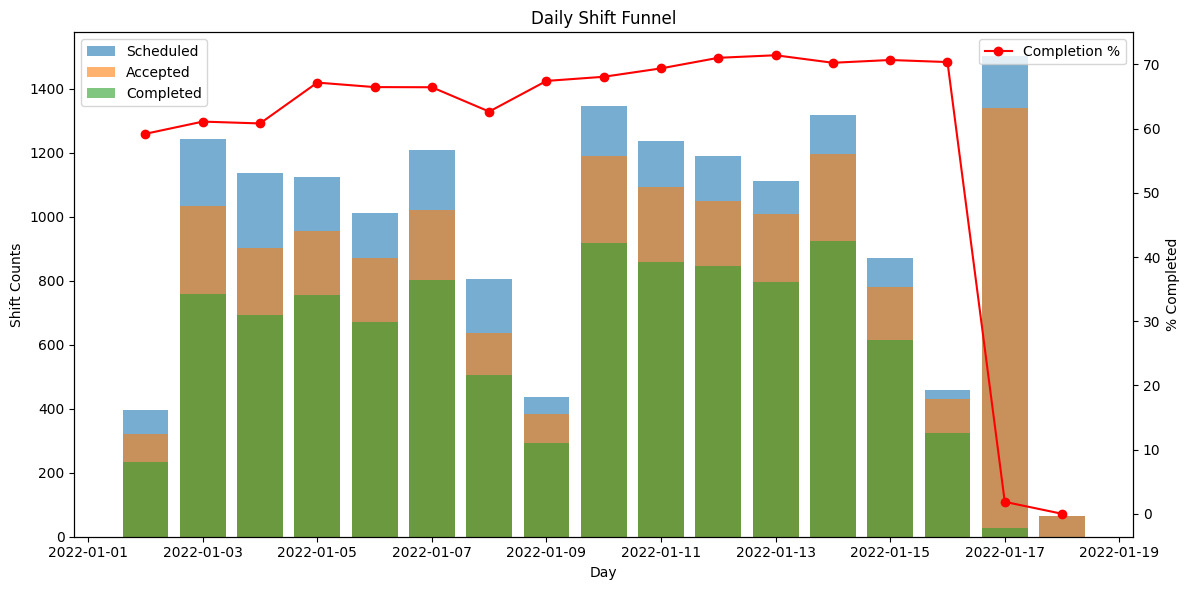

In [112]:
# Daily trend of shifts by scheduled -> accepted -> completed
cleaned['shift_date'] = pd.to_datetime(cleaned['shift_date'])

# Add day
cleaned['day'] = cleaned['shift_date'].dt.to_period('D').apply(lambda r: r.start_time)

# Group by day
daily_funnel = (
    cleaned.groupby('day')
    .agg(
        shifts_scheduled=('shift_UUID', 'count'),
        shifts_accepted=('n_accepted', 'sum'),
        shifts_completed=('completed', 'sum')
    )
    .reset_index()
)

daily_funnel['completion_pct'] = 100 * daily_funnel['shifts_completed'] / daily_funnel['shifts_scheduled']
print(daily_funnel.head())

# Plot: scheduled, accepted, completed + % completed as line
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars: scheduled, accepted, completed
ax1.bar(daily_funnel['day'], daily_funnel['shifts_scheduled'], label='Scheduled', alpha=0.6)
ax1.bar(daily_funnel['day'], daily_funnel['shifts_accepted'], label='Accepted', alpha=0.6)
ax1.bar(daily_funnel['day'], daily_funnel['shifts_completed'], label='Completed', alpha=0.6)

ax1.set_xlabel('Day')
ax1.set_ylabel('Shift Counts')
ax1.set_title('Daily Shift Funnel')
ax1.legend(loc='upper left')

# Line: completion percent
ax2 = ax1.twinx()
ax2.plot(daily_funnel['day'], daily_funnel['completion_pct'], color='red', marker='o', label='Completion %')
ax2.set_ylabel('% Completed')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  shift_dow_name  shifts_scheduled  shifts_accepted  shifts_completed  \
0         Monday              1292             1135               852   
1        Tuesday              4093             3563              1705   
2      Wednesday              2442             2061              1551   
3       Thursday              2315             2006              1601   
4         Friday              2124             1880              1467   
5       Saturday              2528             2221              1730   
6         Sunday              1676             1420              1120   

   completion_pct  
0       65.944272  
1       41.656487  
2       63.513514  
3       69.157667  
4       69.067797  
5       68.433544  
6       66.825776  


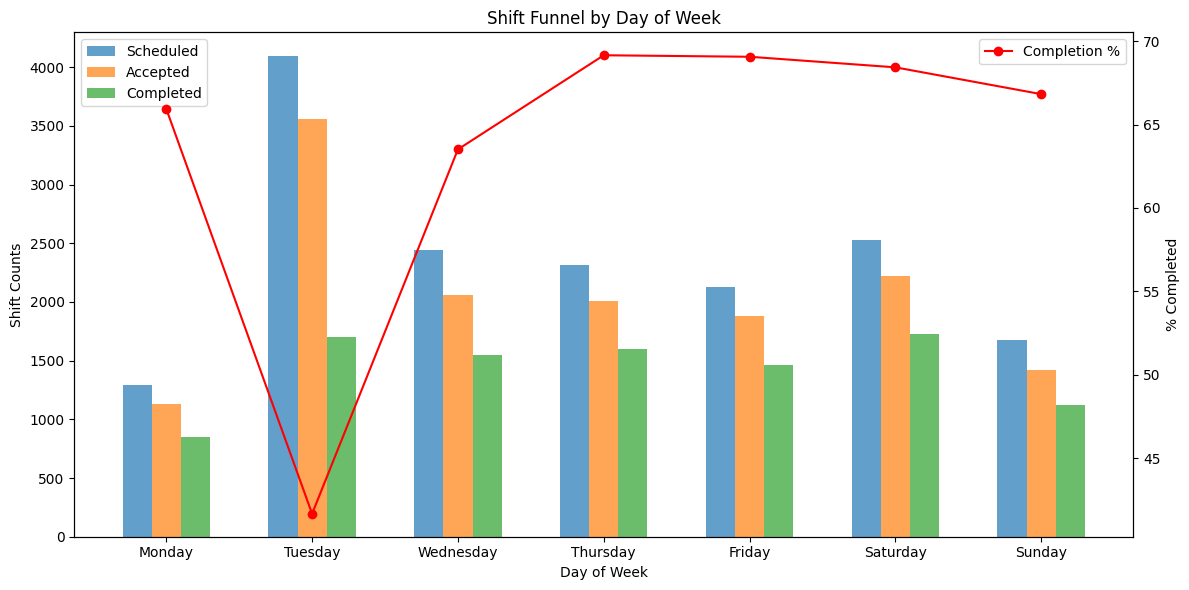

In [113]:
# funnel by day of week
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# If your `shift_dow` is numeric, map to names
# Example:
dow_map = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
    4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
cleaned['shift_dow_name'] = cleaned['shift_dow'].map(dow_map)

# Aggregate by DOW
dow_funnel = (
    cleaned.groupby('shift_dow_name')
    .agg(
        shifts_scheduled=('shift_UUID', 'count'),
        shifts_accepted=('n_accepted', 'sum'),
        shifts_completed=('completed', 'sum')
    )
    .reindex(dow_order)  # ensure correct order
    .reset_index()
)

dow_funnel['completion_pct'] = 100 * dow_funnel['shifts_completed'] / dow_funnel['shifts_scheduled']

print(dow_funnel)

# Make positions
x = np.arange(len(dow_funnel))
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars
ax1.bar(x - width, dow_funnel['shifts_scheduled'], width, label='Scheduled', alpha=0.7)
ax1.bar(x, dow_funnel['shifts_accepted'], width, label='Accepted', alpha=0.7)
ax1.bar(x + width, dow_funnel['shifts_completed'], width, label='Completed', alpha=0.7)

ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Shift Counts')
ax1.set_title('Shift Funnel by Day of Week')
ax1.set_xticks(x)
ax1.set_xticklabels(dow_funnel['shift_dow_name'])
ax1.legend(loc='upper left')

# Line plot for completion %
ax2 = ax1.twinx()
ax2.plot(x, dow_funnel['completion_pct'], color='red', marker='o', label='Completion %')
ax2.set_ylabel('% Completed')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

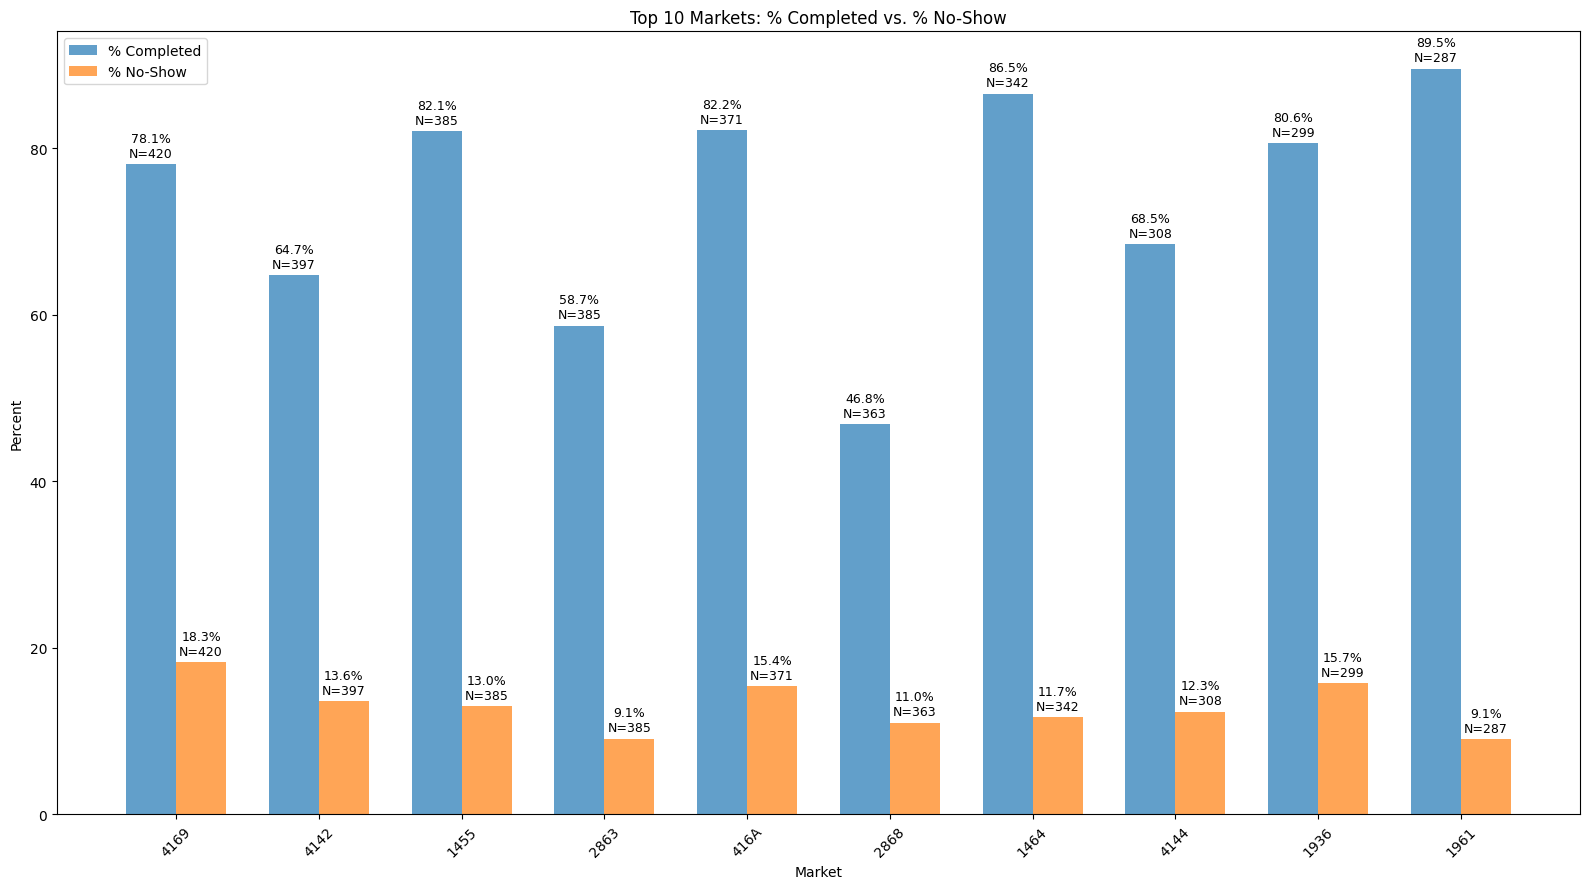

In [101]:
# Breakdown by market
market_summary = (
    cleaned.groupby('market')
    .agg(
        total_shifts=('shift_UUID', 'count'),
        completed=('completed', 'sum'),
        no_shows=('noShow', 'sum'),
        avg_hours=('duration', 'mean')
    )
    .assign(pct_completed=lambda x: 100 * x['completed'] / x['total_shifts'])
    .assign(pct_no_show=lambda x: 100 * x['no_shows'] / x['total_shifts'])
)

top_markets = (
    market_summary
    .sort_values('total_shifts', ascending=False)
    .head(10)
    .reset_index()
)
x = np.arange(len(top_markets))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 9))

# Bars
bars1 = ax.bar(x - width/2, top_markets['pct_completed'], width, label='% Completed', alpha=0.7)
bars2 = ax.bar(x + width/2, top_markets['pct_no_show'], width, label='% No-Show', alpha=0.7)

# Labels, axes, title
ax.set_ylabel('Percent')
ax.set_xlabel('Market')
ax.set_title('Top 10 Markets: % Completed vs. % No-Show')
ax.set_xticks(x)
ax.set_xticklabels(top_markets['market'], rotation=45)
ax.legend()

# Add data labels for each bar
for i, bar in enumerate(bars1):
    height = bar.get_height()
    total = top_markets.loc[i, 'total_shifts']
    ax.annotate(f"{height:.1f}%\nN={total}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    total = top_markets.loc[i, 'total_shifts']
    ax.annotate(f"{height:.1f}%\nN={total}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [119]:
output = cleaned.groupby(['market', 'store', 'role', 'shift_date', 'shift_dow', 'shift_hour'], as_index=False).agg(unique_shifts=('shift_UUID', 'nunique'),
                                                                                                          avg_duration=('duration', 'mean'),
                                                                                                          total_duration=('duration', 'sum'),
                                                                                                          avg_rate=('rate', 'mean'),
                                                                                                          total_shifts_sent=('n_sent', 'sum'),
                                                                                                          total_shifts_not_sent=('n_not_sent', 'sum'),
                                                                                                          total_eligible_partners=('eligble_partners', 'sum'),
                                                                                                          total_shifts_sent_to_partners=('n_sent_partners', 'sum'),
                                                                                                          total_shifts_accepted=('n_accepted', 'sum'),
                                                                                                          total_partners_accepting_shifts=('n_accepted_partners', 'sum'),
                                                                                                          total_no_accepts=('no_accepts', 'sum'),
                                                                                                          total_canceled_early=('canceled_early', 'sum'),
                                                                                                          total_canceled_late=('canceled_late', 'sum'),
                                                                                                          total_noShow=('noShow', 'sum')
                                                                                                          )
output

,market,store,role,shift_date,shift_dow,shift_hour,unique_shifts,avg_duration,total_duration,avg_rate,total_shifts_sent,total_shifts_not_sent,total_eligible_partners,total_shifts_sent_to_partners,total_shifts_accepted,total_partners_accepting_shifts,total_no_accepts,total_canceled_early,total_canceled_late,total_noShow
0,1411,2705321.0,Role 1,2022-01-02,1,16,1,3.5,3.5,13.0,1,0,152,62,1,2,0,0,0,1
1,1411,2705321.0,Role 1,2022-01-09,1,17,1,3.5,3.5,13.0,1,0,583,369,1,1,0,0,0,0
2,1411,2705321.0,Role 1,2022-01-16,1,17,1,3.5,3.5,12.0,1,0,739,739,1,4,0,0,0,1
3,1411,2705321.0,Role 3,2022-01-08,7,17,1,3.5,3.5,13.0,1,0,214,133,1,2,0,0,0,0
4,1411,2705321.0,Role 3,2022-01-15,7,17,1,3.5,3.5,12.0,1,0,51,51,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15982,433A,4701597.0,Role 3,2022-01-05,4,10,1,4.0,4.0,13.0,1,0,10,6,1,1,0,0,0,0
15983,433A,4701597.0,Role 3,2022-01-07,6,20,1,4.0,4.0,13.0,1,0,10,10,1,1,0,0,0,0
15984,433A,4701597.0,Role 3,2022-01-11,3,17,1,4.0,4.0,13.0,1,0,13,8,1,3,0,0,0,0
15985,433A,4701597.0,Role 3,2022-01-12,4,19,1,4.0,4.0,13.0,1,0,17,9,1,3,0,0,1,0


In [ ]:
# load to postgres
from sqlalchemy import create_engine

name = 'shiftstats'
user = 'cadan'
host = 'localhost'
pass = 'my_super_secure_password'
port = '5432'

engine = create_engine(f'postgresql+psycopg2://{user}:{pass}@{host}:{port}/{name}')

# Write the transformed df to Postgres
clean.to_sql('metrics_daily', engine, if_exists='replace', index=False)